# GENERAL MAPPING FUNCTION FOR PUGET SOUND! ALL YOUR PUGET SOUND MAPPING NEEDS HERE!

### Isabelle Brandicourt, 03-05-2025

In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource
import pandas as pd
import rasterio.plot
from matplotlib_scalebar.scalebar import ScaleBar


In [7]:
def bathy_load(filepath):
    with rasterio.open(filepath) as src:
        bathy = src.read(1)  # Read the first band (bathymetry data)
        transform = src.transform
        crs = src.crs
        height, width = bathy.shape

        # Generate longitude and latitude arrays
        xlon = np.linspace(transform[2], transform[2] + transform[0] * width, width)
        ylat = np.linspace(transform[5], transform[5] + transform[4] * height, height)

    return bathy, xlon, ylat, transform, crs


def Sam_plot(bathy, lat, long, xlon, ylat, cable1, cable2, cable3):
    with rasterio.open(bathy) as dataset:
        bathy = dataset.read(1)
        print(bathy)
        transform = dataset.transform
        bounds = dataset.bounds
        nodata = dataset.nodata
    rows, cols = bathy.shape
    x = np.linspace(bounds.left, bounds.right, cols)
    y = np.linspace(bounds.top, bounds.bottom, rows)
    lon_grid, lat_grid = np.meshgrid(x, y)
    bathy = np.where(bathy == nodata, np.nan, bathy)

    # Separate depth and elevation
    depth = np.where(bathy < 0, bathy, np.nan)
    elevation = np.where(bathy >= 0, bathy, np.nan)

    plt.rcParams.update({"font.size": 20})
    plt.figure(figsize=(10, 10),dpi=600)
    cp_depth = plt.contourf(lon_grid, lat_grid, depth, levels=18, cmap="bone")
    cbar_depth = plt.colorbar(cp_depth, label="Depth (m)")
    cp_elevation = plt.contourf(lon_grid, lat_grid, elevation, levels=20, cmap="copper", alpha=0.6)
    #plt.colorbar(cp_elevation, label="Elevation (m)")

    # Plot cables
    plt.plot(cable1["Long"], cable1["Lat"], color="green", linewidth=3, label="Clinton-Hat Cable, 6 km")
    plt.plot(cable2["Long"], cable2["Lat"], color="black", linewidth=3, label="Clinton-Everett Cable, 11 km")
    plt.plot(cable3["longitude"], cable3["latitude"], color="m", linewidth=3, label="Whidbey-Seattle Cable, 44 km")

    plt.xlabel("Longitude", fontsize=20)
    plt.xticks(ticks=plt.xticks()[0], labels=[label if i % 2 == 0 else "" for i, label in enumerate(plt.xticks()[1])])
    plt.ylabel("Latitude", fontsize=20)
    #plt.title("DAS Cables with Bathymetry", fontsize=16)
    plt.xlim(-122.6,-122.2)
    plt.ylim(47.8, 48.2)
    plt.legend(loc="upper left", fontsize=14)

    # Add scalebar
    scalebar = ScaleBar(dx=transform[0] * 111320, units="km", location="lower right")
    plt.gca().add_artist(scalebar)

    return depth, elevation, lon_grid, lat_grid, xlon, ylat


def plot_just_map(bathy, lat, long, xlon, ylat):
    vmin = -250
    vmax = 100
    
    # Calculate the percentage of the colormap that should be water vs land
    total_range = vmax - vmin
    water_range = 0 - vmin  # from vmin to 0
    water_fraction = water_range / total_range
    
    # Custom colormap, combine colors for water and land
    n_water = int(100 * water_fraction)
    n_land = int(100 * (1 - water_fraction))
    water_colors = plt.cm.Blues(np.linspace(1, 0.1, n_water))
    land_colors = plt.cm.terrain(np.linspace(1, 0.8, n_land))
    all_colors = np.vstack((water_colors, land_colors))
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', all_colors, N=256)
    
    # Create BoundaryNorm to force the transition at 0
    bounds = np.linspace(vmin, vmax, 256)
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    # Set the extent of the plot and light source
    extent = [xlon[0], xlon[1], ylat[0], ylat[1]]
    ls = LightSource(azdeg=350, altdeg=45)
    
    plt.figure(figsize=(15, 10))
    #ax = plt.gca()
    #rgb = ls.shade(bathy, cmap=custom_cmap, vert_exag=0.1, norm=norm)
    #plot = ax.imshow(rgb, extent=extent, aspect='equal', origin='lower')

    plt.contourf(bathy, cmap='bone', extent=extent, aspect='equal', origin='lower', norm=norm)
    print(bathy)

    return


def plot_map(mode9, c_h, c_e, w_s, bathy, seattle, sb_hydrophone, lat, long, xlon, ylat, title):
    vmin = -250
    vmax = 100
    
    # Calculate the percentage of the colormap that should be water vs land
    total_range = vmax - vmin
    water_range = 0 - vmin  # from vmin to 0
    water_fraction = water_range / total_range
    
    # Custom colormap, combine colors for water and land
    n_water = int(100 * water_fraction)
    n_land = int(100 * (1 - water_fraction))
    water_colors = plt.cm.Blues(np.linspace(1, 0.1, n_water))
    land_colors = plt.cm.terrain(np.linspace(1, 0.8, n_land))
    all_colors = np.vstack((water_colors, land_colors))
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', all_colors, N=256)
    
    # Create BoundaryNorm to force the transition at 0
    bounds = np.linspace(vmin, vmax, 256)
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    # Set the extent of the plot and light source
    extent = [xlon[0], xlon[1], ylat[1], ylat[0]]
    ls = LightSource(azdeg=350, altdeg=45)
    
    fig, ax = plt.subplots(figsize=(15, 10))    #ax = plt.gca()
#    rgb = ls.shade(bathy, cmap=custom_cmap, vert_exag=0.1, norm=norm)
#    plot = ax.imshow(rgb, extent=extent, aspect='equal', origin='lower')

    # Plot bathymetry first (contourf)
    cf = ax.contourf(bathy, cmap='bone', extent=extent, aspect='equal', origin='lower', norm=norm, zorder=0)

    # Overlay lines and markers
    ax.plot(mode9['longitude'], mode9['latitude'], 'tab:red', linewidth=3, label='Whidbey-Seattle Mode 9')
    ax.plot(w_s['longitude'], w_s['latitude'], 'tab:red', linewidth=1, label='Whidbey-Seattle Cable')
    ax.plot(c_h['Long'], c_h['Lat'], 'tab:purple', linewidth=1, label='Clinton-Hat Cable')
    ax.plot(c_e['Long'], c_e['Lat'], 'tab:green', linewidth=1, label='Clinton-Everett Cable')
    ax.contour(bathy, levels=[0], colors='k', extent=extent, linewidths=0.5)  # Coastline
    ax.plot(seattle[1], seattle[0], marker='*', color='red', markersize=20)
    ax.plot(sb_hydrophone[1], sb_hydrophone[0], marker='*', color='red', markersize=20)

    # Force axis limits to match bathy extent
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[3], extent[2])

    # Add colorbar and legend
    plt.colorbar(cf, ax=ax, label='Elevation (m)')
    ax.legend()
    plt.show()

    return

Plot the entire Whidbey Tel cable, the Mode9 section, and all sightings from Acartia.io after Mode9 was illuminated Then crop to the lat and lon of interest and filter the sightings by time around a detection on the hydrophone.

/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/tmp/ipykernel_148894/735066770.py:89: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(bathy, cmap='bone', extent=extent, aspect='equal', origin='lower', norm=norm)


[[         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 ...
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]]
[[         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 [         0          0          0 ... 4294967295 4294967295 4294967295]
 ...
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]
 [4294967295 4294967295 4294967295 ... 4294967295 4294967295 4294967295]]


/tmp/ipykernel_148894/735066770.py:125: UserWarning: The following kwargs were not used by contour: 'aspect'
  cf = ax.contourf(bathy, cmap='bone', extent=extent, aspect='equal', origin='lower', norm=norm, zorder=0)
/home/isabrand/.conda/envs/odl/lib/python3.12/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


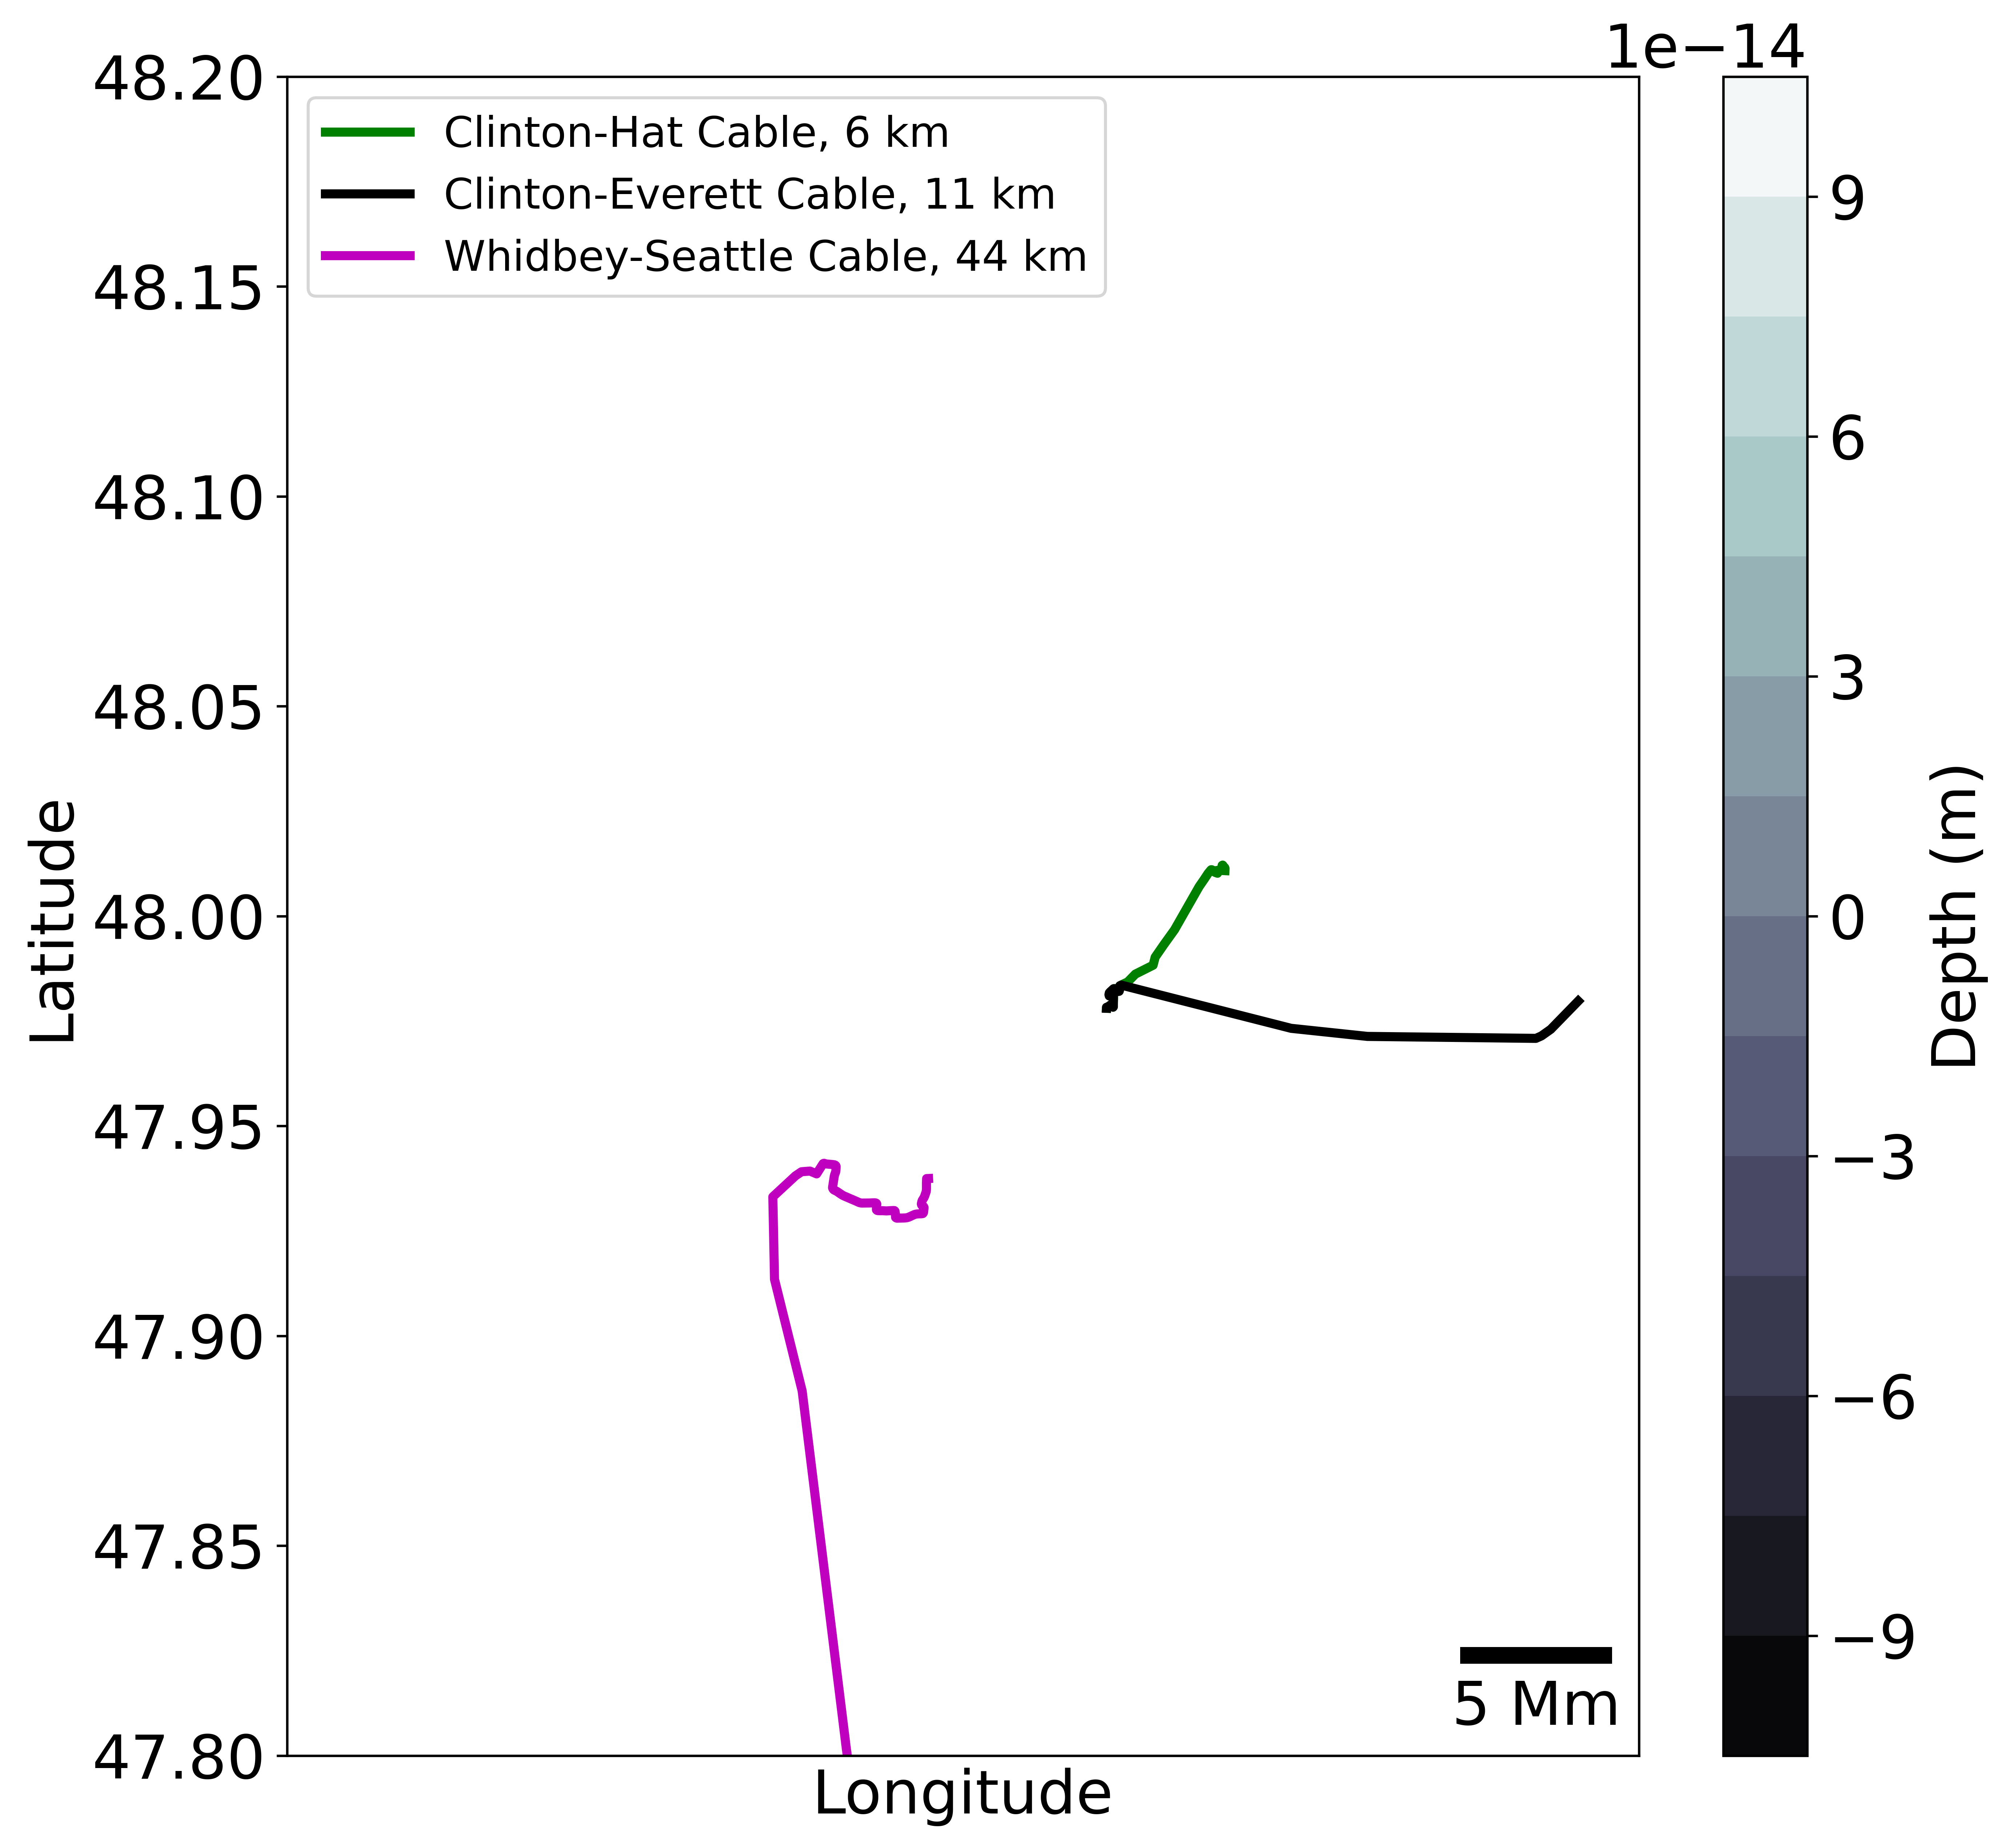

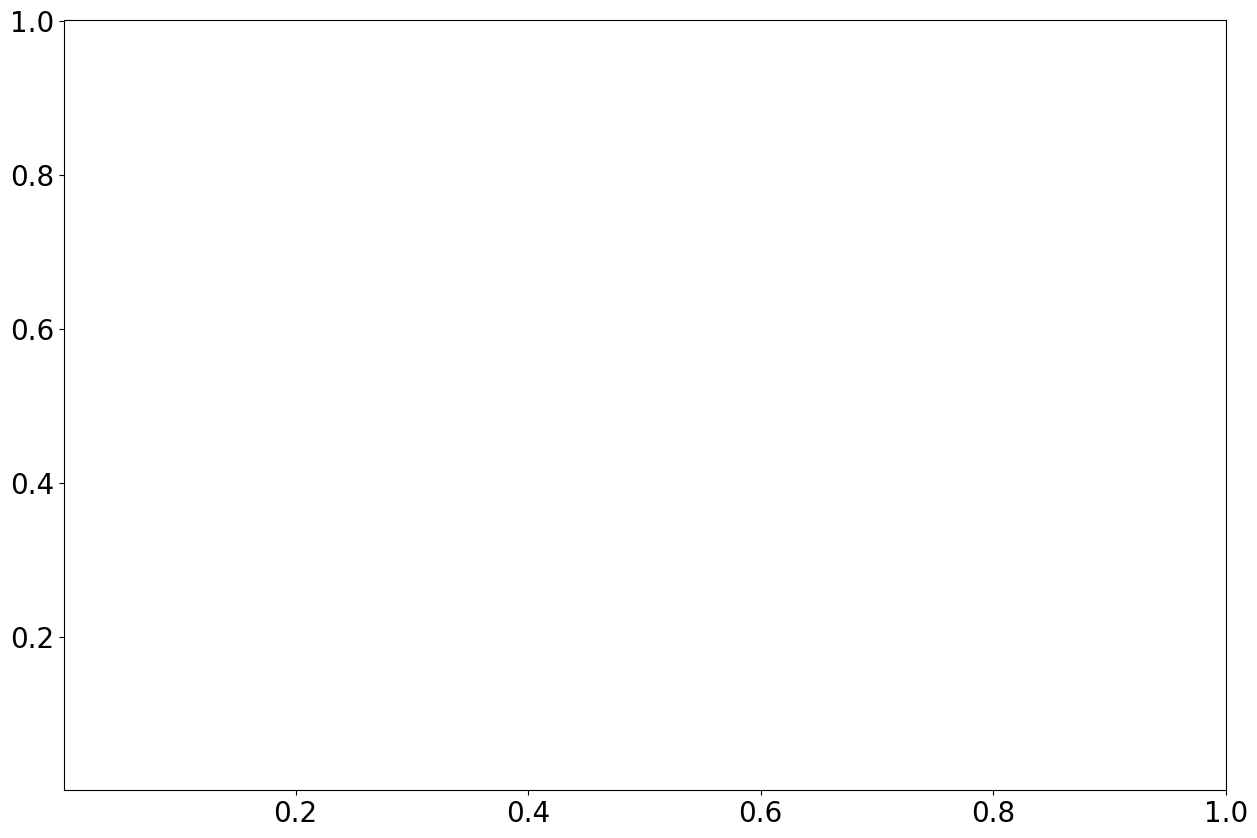

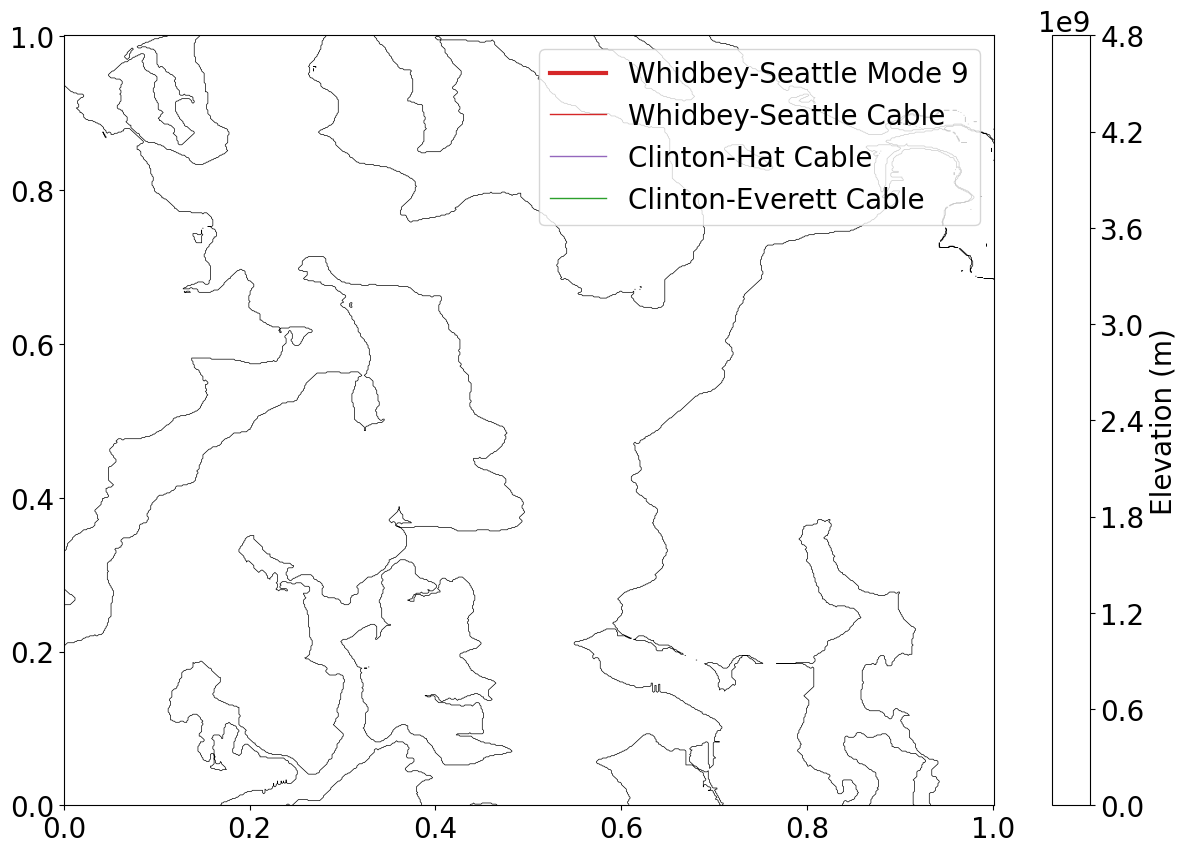

In [8]:
bathy, xlon, ylat, transform, crs = bathy_load('/home/isabrand/Documents/ODL/Bathymetry/SalishSea.tiff')
bathy_file = '/home/isabrand/Documents/ODL/Bathymetry/SalishSea.tiff'

clinton_hat = pd.read_csv("/home/isabrand/Documents/ODL/Bathymetry/Clinton_Hat_cablepath.csv")
clinton_ev = pd.read_csv("/home/isabrand/Documents/ODL/Bathymetry/Clinton_Everett_cablepath.csv")
whidbey_sea = pd.read_csv("/home/isabrand/Documents/ODL/Bathymetry/Whidbey_Seattle_cablepath.csv")
whidbey_sea_mode9 = pd.read_csv("/home/isabrand/Documents/ODL/Bathymetry/Whidbey_Seattle_Mode9_cablepath.csv")

seattle = [47.6061, -122.3328]
sb_hydrophone = [47.865395, -122.33268]

ss_lat = [47.5, 48.3]
ps_lat = [47.55, 48.1]  # for the Puget Sound map
ss_long = [-122.7, -122.2]        # for the whole Salish Sea map
ps_long = [-122.5, -122.2]         # for the Puget Sound map

Sam_plot(bathy_file, ps_lat, ps_long, xlon, ylat, clinton_hat, clinton_ev, whidbey_sea)
plot_just_map(bathy, ps_lat, ps_long, xlon, ylat)
plot_map(whidbey_sea_mode9, clinton_hat, clinton_ev, whidbey_sea, bathy, seattle, sb_hydrophone, ps_lat, ps_long, xlon, ylat, title='Puget Sound Map')